**Tutorial by:**<br>
` Harsh Kumar (CFA)`

## Main Motive
 Measuring brightness of astronomical sources i.e. Understanding the concept of photometry.

## Key steps
- Extracting sources form image.
- Cross-match with some external catalogue to get Zeropoints.
- Calculating magnitudes using aperture photometry standardising the magnitudes.
- Performing PSF-fit photometry.

**Here are a few important notes before we get started:-**
- python3 environment is recommended for this notebook with the following modeules installed: (you can also make use of conda to make such an environment.)
- numpy
- matplotlib
- astropy
- photutils
- astroquery

If any of these modules are not installed, a simple pip insatll might do the job. i.e.  `pip install <module>`. You can also use conda to install these modules if you are working in a conda environment. If you are working with conda environment, you might want to make sure that your environment is active and pip is installed within your working conda environment to your conda environment

**We also require a few additional astrometic software dependency :-**
- SExtractor (source code Download link: https://www.astromatic.net/software)
- PSFEx    (source code Download link:  https://www.astromatic.net/software)



## Let's get started

Once again we start by importing necessary python modules. Do not run the next cell if you have all packages installed. 

In [1]:
# ! pip install astroquery
# ! pip install astroscrappy
# ! pip install astropy
# ! sudo apt-get install psfex
# ! sudo add-apt-repository universe
# ! sudo apt-get install alien
# ! wget http://www.astromatic.net/download/sextractor/sextractor-2.19.5-1.x86_64.rpm
# ! alien -i sextractor-2.19.5-1.x86_64.rpm
# ! pip install photutils

In [2]:
import os
import glob
import numpy as np 
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import subprocess
import astropy.units as u
from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clipped_stats, sigma_clip
from photutils import SkyCircularAperture, SkyCircularAnnulus, aperture_photometry
from astroquery.vizier import Vizier
from astropy.io import ascii
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.table import Table
from tqdm import tqdm_notebook as tqdm

In [3]:
## Simple decorative display function. Please ignore
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    
def display_text(text):
    print( color.GREEN + '*'+'-'*(10+len(text))+'*' )
    print('*'+('-'*3)+(' '*2)+ color.GREEN+ color.PURPLE+str(text)+ color.GREEN+(' '*2)+('-'*3)+'*')
    print('*'+'-'*(10+len(text))+'*' +"\n") 
    
def wait_request():
    print('This step may take a while. Please wait 🙏.\n')

In our last notebook, we have calibrated data and made it ready for the actual science purpose. It's time to use that. Do you remember where that data is ? Let's start by finding the calibrated data. All the calibrated / reduced data sits in reduced directory. So, reduced path will be the the one to go for in most of our processes in this notebook.  

In [4]:
#Finding data 🧐

cwd = os.getcwd() # current working directory
science_path = os.path.join(cwd,'data','science')
reduced_path = os.path.join(cwd,'data','reduced')  # all processed data sits here. 

- Visualise the image to confirm that we are working with the correct data. Check whether it looks good or not. We have a few images available. You are free to use any of the image in theory. But, let's use the same image to compare the results. 

In [5]:
os.chdir(reduced_path)
file_list = glob.glob("*.proc.fits")
print("found following {} files: {}".format(len(file_list), file_list))

found following 4 files: ['C0_20181013-201128-360.wcs.proc.fits', 'C0_20181013-174714-557.wcs.proc.fits', 'C0_20181013-183430-709.wcs.proc.fits', 'C0_20181013-190734-760.wcs.proc.fits']


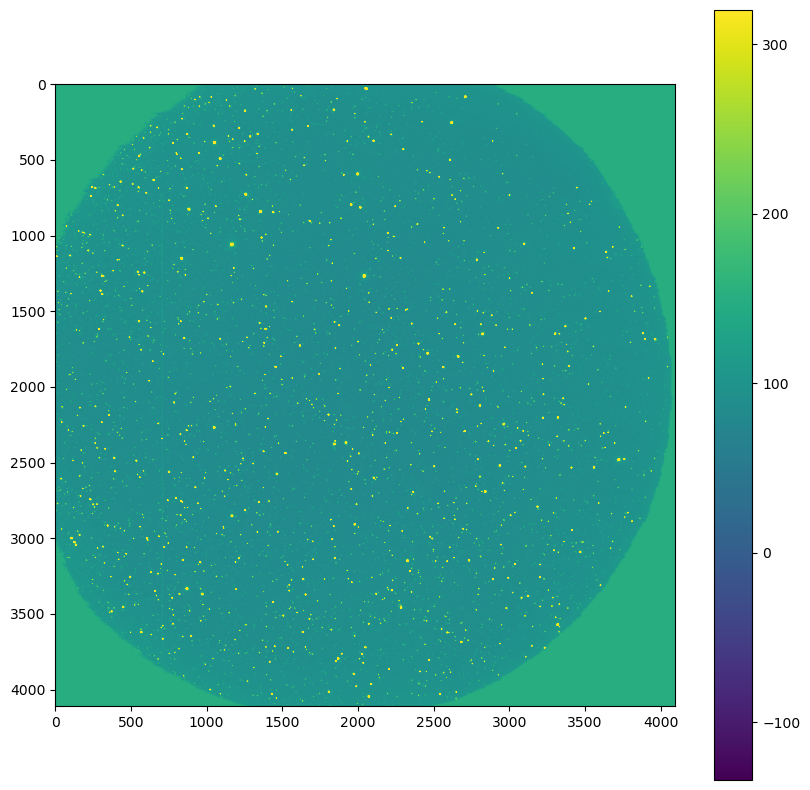

In [6]:
image = file_list[3]
hdu = fits.open(image)
data = hdu[0].data
header = hdu[0].header
mean, med, std = sigma_clipped_stats(data)
plt.figure(figsize= (10,10))
plt.imshow(data, vmin = med - 10*std, vmax = med + 10*std)
plt.colorbar()

# Photometry :  Photo (photons) + metry (measurement)
It's a technique by which we measure the Flux or intensity of the light emiited by a source. In other words, it is a method to measure the brightness of sources. We detect photons from the source onto a CCD camera and measure the number of photon collected in a given time. An estimation of photon flux from any particular source gives us its brightness. In astronomy we represents it in terms of magnitude of a source. Magnitude is represented as:

<center>
  m = -2.5 * log10(Flux)
</center>     

Here `m` is called "instrumental magnitude of a source". As we can see from the formula that it depends on Flux i.e.  number of photons collected by camera for a particular source. Number of photons collected by camera greatly depends on its specification and telescope assembly. Hence, this magnitude cooresponds to a particular camera assembly. Different cameras may register different Flux for the same source depending on various factors. Hence, the instrumental magnitude may vary with camera. As instrumental magnitude is not a standard thing we cannot use it directly on global scale. Therefore, we have to standardise it. We will do that later. Let's first understand how to estimate the instrumental magnitude.

# Two types of photometry:

## Aperture Photometry and PSF fit photometry

# Extracting sources from image
Now, we will extract sources from our image using `SExtractor`. `SExtractor` is a very versatile software, widely used by Astro commnunity for detecting sources from a fits images. Along with detecting sources it can also perform aperture and PSF photometry on sources if provided necessary parameters. These parameters are usally stored in the configuration file. `SExtractor` sources detection methods has been trained on various telescope images and are quite reliable. Although there exist better algorithms to perform photometry on sources, hardly any other software is as reliable as `SExtractor` in detecting sources. You can read more about `SExtractor` at  https://sextractor.readthedocs.io/en/latest/Introduction.html and https://www.astromatic.net/pubsvn/software/sextractor/trunk/doc/sextractor.pdf .



In [7]:
# Let's define input and output file names
conf_file = 'config.sex'      # configuration file for SExtractor. This files consist of values of differet params
parameter_file = 'apr.param'  # parameter file which tells what params to be stored in catalogue file. 
out_cat = image + ".cat"      # Resulted catalogue from SExtractor consisting the sources info in the image.

In [8]:
command =  ['sex', image, '-c', conf_file, '-CATALOG_NAME', out_cat, '-PARAMETERS_NAME', parameter_file]
print('SExtrator command is : %s' % command)
try:
    display_text("Running SExtractor")
    rval = subprocess.call(command)
    display_text("Process complete")
except subprocess.CalledProcessError as err:
    print('An error occuered while running SExtractor. Please try to run it manually through terminal.')
    sys.exit(1)

SExtrator command is : ['sex', 'C0_20181013-190734-760.wcs.proc.fits', '-c', 'config.sex', '-CATALOG_NAME', 'C0_20181013-190734-760.wcs.proc.fits.cat', '-PARAMETERS_NAME', 'apr.param']
*----------------------------*
*---  Running SExtractor  ---*
*----------------------------*



> 
----- SExtractor 2.28.0 started on 2024-07-08 at 13:25:04 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for C0_20181013-190734-760.wcs.proc.fits
----- Measuring from: C0_20181013-190734-760.wcs.proc.fits
      " " / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 93.183     RMS: 7.35186    / Threshold: 36.7593    
> Scanning image
> Line:  

*--------------------------*
*---  Process complete  ---*
*--------------------------*



      Objects: detected 6472     / sextracted 6160            

> Closing files
> 
> All done (in 4.7 s: 866.3 lines/s , 1299.1 detections/s)


In [9]:
def load_catalogue(catalogue, frames=1):
    """
    Load the sextractor generated catalogue in form of an astropy table.
    """
    if frames >0:
        frames = frames*2
    source_table= Table.read(catalogue, hdu=frames)
    return source_table

In [10]:
local_sources = load_catalogue(out_cat)
print(local_sources.colnames)
print(local_sources)

['VIGNET', 'X_IMAGE', 'Y_IMAGE', 'XWIN_IMAGE', 'YWIN_IMAGE', 'ERRAWIN_IMAGE', 'ERRBWIN_IMAGE', 'ALPHAWIN_J2000', 'DELTAWIN_J2000', 'FLUX_RADIUS', 'FWHM_WORLD', 'FLUX_AUTO', 'FLUXERR_AUTO', 'SNR_WIN', 'ELONGATION', 'FLUX_MAX', 'MAG_AUTO', 'MAGERR_AUTO', 'FLAGS', 'BACKGROUND', 'CLASS_STAR', 'FLUX_APER', 'FLUXERR_APER', 'MAG_APER', 'MAGERR_APER']
           VIGNET              X_IMAGE     Y_IMAGE    XWIN_IMAGE  YWIN_IMAGE ... CLASS_STAR          FLUX_APER                   FLUXERR_APER               MAG_APER           MAGERR_APER     
             ct                  pix         pix         pix         pix     ...                         ct                           ct                      mag                  mag         
---------------------------- ----------- ----------- ----------- ----------- ... ---------- ---------------------------- ---------------------------- -------------------- --------------------
    41.58768 ..    -10.75456    882.2867     69.1553    882.2868     69.1553 .

# Source selection
Let's select the good sources from the sextrator catalogue. SExtractor flags the sources using 8 flag bits depending on various factors. You can read about the SExtrator flags in details here: https://sextractor.readthedocs.io/en/latest/Flagging.html

In [11]:
unflagged_sources = local_sources[(local_sources['FLAGS'] == 0)]
print((unflagged_sources))

           VIGNET              X_IMAGE     Y_IMAGE    XWIN_IMAGE  YWIN_IMAGE ... CLASS_STAR          FLUX_APER                   FLUXERR_APER               MAG_APER           MAGERR_APER     
             ct                  pix         pix         pix         pix     ...                         ct                           ct                      mag                  mag         
---------------------------- ----------- ----------- ----------- ----------- ... ---------- ---------------------------- ---------------------------- -------------------- --------------------
   0.3305283 ..     1.121063   1565.9133     28.4810   1565.8421     28.4521 ...      0.404     10171.08 ..      19676.5     32.51483 ..     123.7298 -10.0184 .. -10.7349   0.0035 ..   0.0068
    14.22773 ..   -0.7763519   1203.7335     22.1027   1203.6856     22.0430 ...      0.214     2176.736 ..     5086.727     32.44827 ..     123.7298  -8.3445 ..  -9.2661   0.0162 ..   0.0264
    7.511497 ..     11.28208   1510.6758

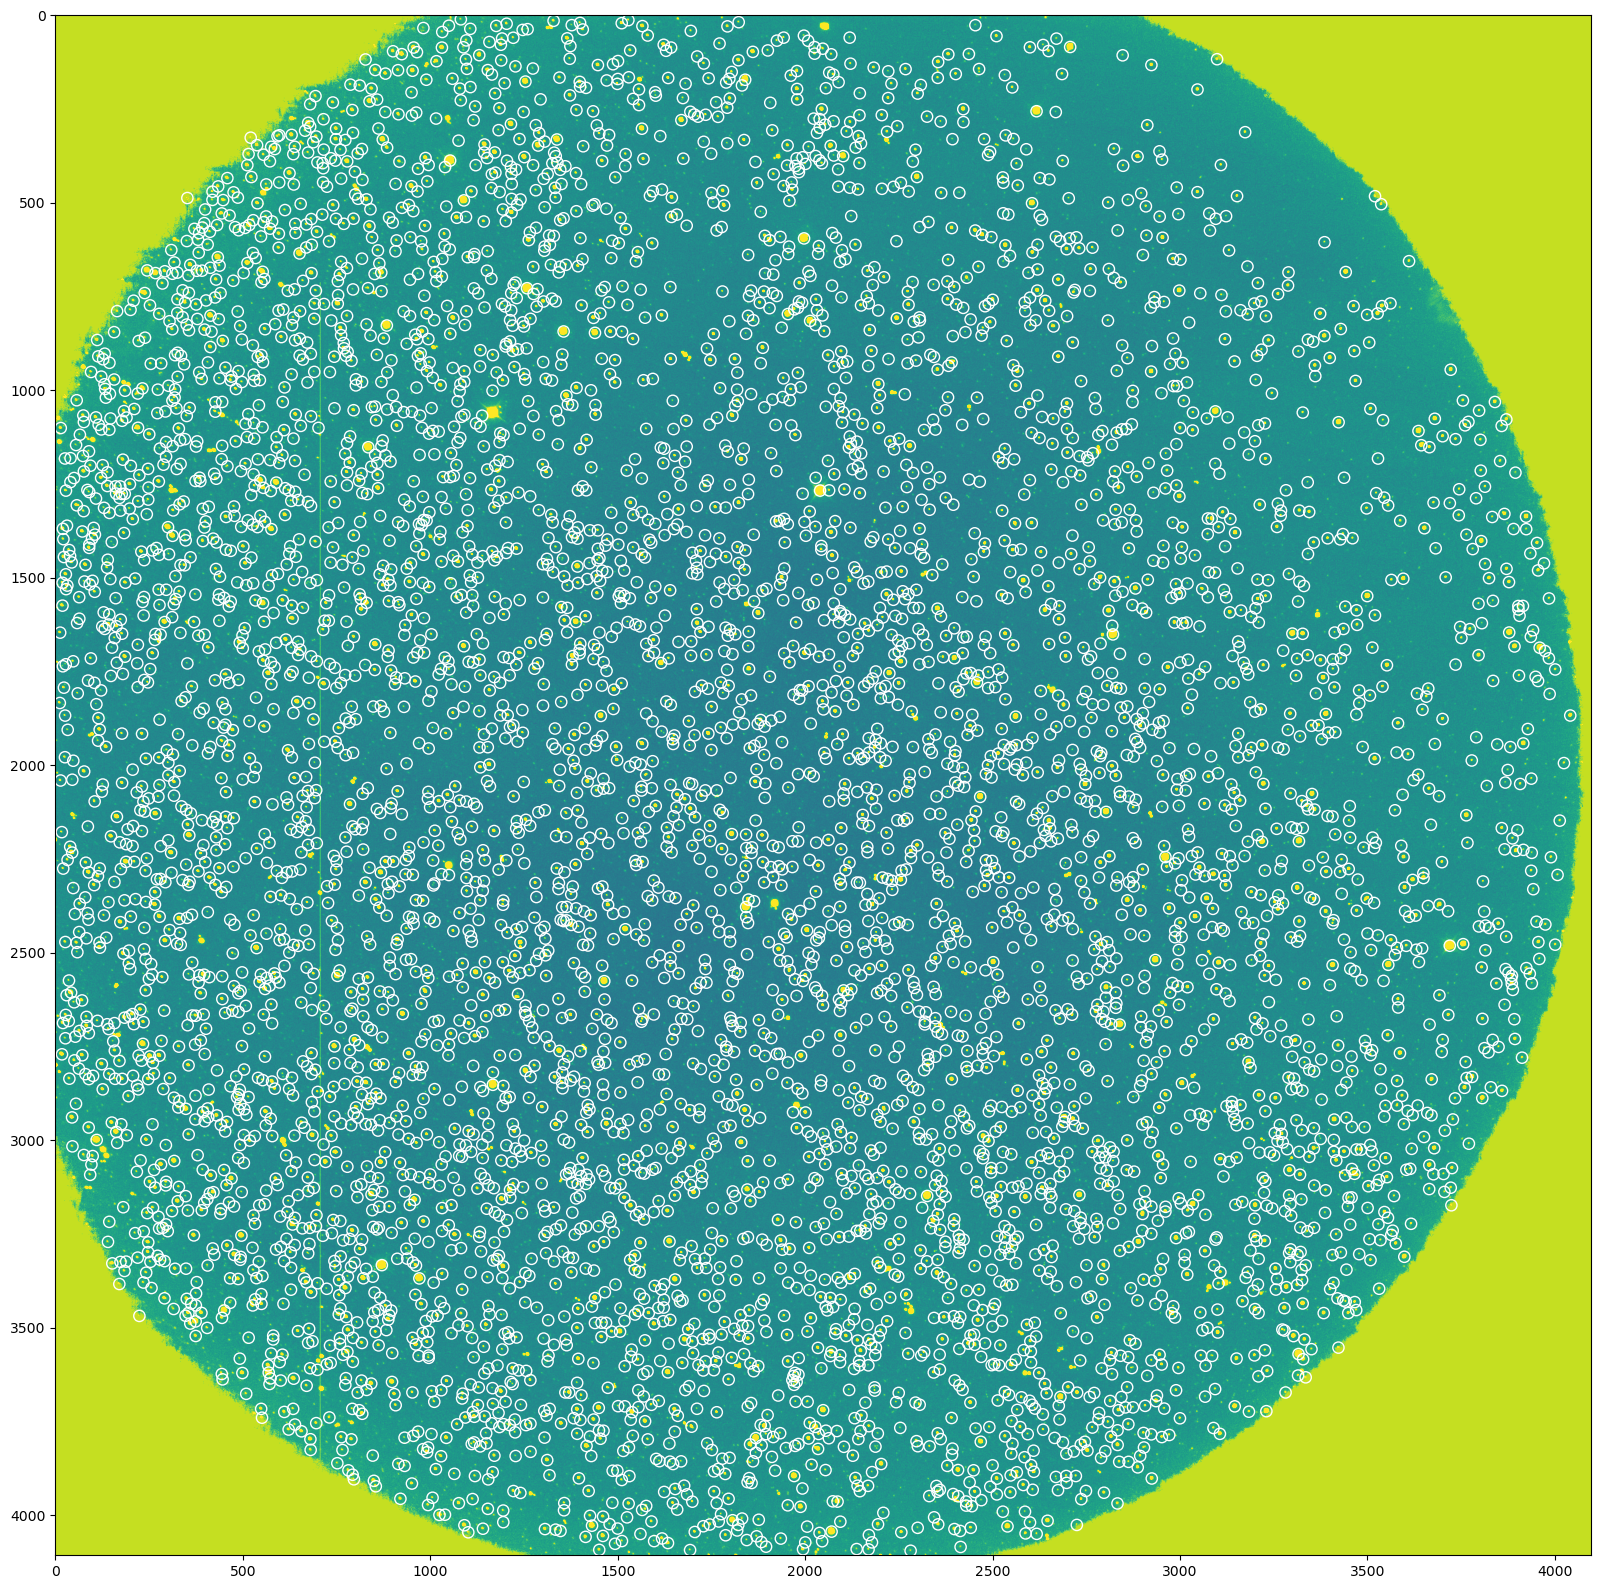

In [12]:
from matplotlib.patches import Circle
fig = plt.figure(figsize=(20,20))
ax = fig.gca()
plt.imshow(data, vmin=med-3*std, vmax=med+3*std)
# Marking the position of sources in image.
stars = [Circle((obj['XWIN_IMAGE'], obj['YWIN_IMAGE']), radius = 15, edgecolor='w', facecolor='None') for obj in unflagged_sources]
for star in stars:
    ax.add_artist(star)
plt.show()

In [13]:
w = WCS(header)
[ra_cent, dec_cent] = w.all_pix2world(header["NAXIS2"]/2, header["NAXIS1"]/2, 1)   # centeral ra dec of the image.
query_radius = 23 # catalogue query radius around central ra dec in arcmins.
minmag = 14    # maximum magnitude cut to get rid of very bright stars
maxmag = 18    # minimum magnitude cut to get rid of very faint stars    

# Keep in mind: more the magnitude of the star, less brighter it is.

pan_catnum = "II/349"  #This is the catalog number of PanSTARRS DR1 in Vizier.
#  Use 'V/147' to query SDSS catalogue in Vizier. You have to replace colomn header names in last line as those are different for SDSS.

display_text('Making a vizier query for %s catalogue number in %.f arcmin radius around Ra %.5f, Dec %.5f'%(pan_catnum, query_radius, ra_cent, dec_cent))
wait_request()
try:
    v = Vizier(columns=['*'], column_filters={"gmag":"<%.1f"%maxmag, "e_gmag":"<<1.086/3", "Nd":">6"}, row_limit=-1)
    Q = v.query_region(SkyCoord(ra = ra_cent, dec = dec_cent, unit = (u.deg, u.deg)), radius = str(query_radius)+'m', catalog=pan_catnum, cache=False)
    good_stars = Q[0][Q[0]['gmag'] > minmag]  # Neglecting very bright stars from the queried catalogue.
    print("\n\n Vizier query resulted %.f sources in the queried field after applying the mentioned filtering criteria."%len(good_stars))
except:
    print('An error occured in querying vizier database. Please check whether your internet conection is working or not.')

# Convert the queried source positions to image pixel position using world2pix conversion for later use.
cat_localcoords = w.all_world2pix(good_stars['RAJ2000'], good_stars['DEJ2000'], 1) # position of queried sources in the image.

*-----------------------------------------------------------------------------------------------------------------*
*---  Making a vizier query for II/349 catalogue number in 23 arcmin radius around Ra 324.80475, Dec 46.72743  ---*
*-----------------------------------------------------------------------------------------------------------------*

This step may take a while. Please wait 🙏.



 Vizier query resulted 5192 sources in the queried field after applying the mentioned filtering criteria.


In [14]:
print(good_stars)

   RAJ2000       DEJ2000          objID         f_objID  Qual  e_RAJ2000    e_DEJ2000       _tab1_10     Ns  Nd ...  e_zmag  zKmag  e_zKmag  zFlags    ymag   e_ymag  yKmag  e_yKmag  yFlags 
     deg           deg                                           arcsec       arcsec           d                ...   mag     mag     mag              mag     mag     mag     mag           
------------- ------------- ------------------ --------- ---- ------------ ------------ --------------- --- --- ... ------- ------- ------- -------- ------- ------- ------- ------- --------
324.378397160  46.482544870 163773243784199757 503635968   60       0.0091       0.0099 55861.623344910   5  71 ...  0.0014 15.0457  0.0021   115000 14.7533  0.0046 14.8224  0.0047   115000
324.354560520  46.504534980 163803243545716128 503635968   60       0.0063       0.0115 55842.656574070   5  62 ...  0.0052 15.5591  0.0032   115000 15.3389  0.0062 15.5173  0.0389   115000
324.335772010  46.521772780 163823243358056814 503

# Exercise time !


### Plot where the queried sources lie in the image. You will have to do something like we did in the case of unflagged sources.  Add a cell below for the same.


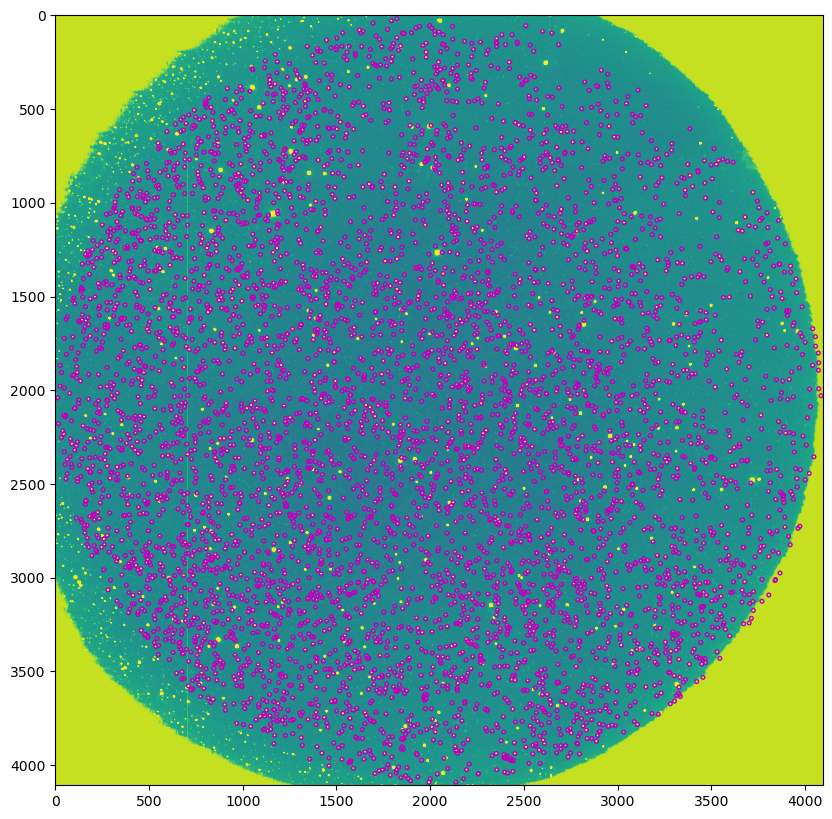

In [17]:
# Exercise 1 solution here

fig = plt.figure(figsize=(10,10))
ax = fig.gca()
plt.imshow(data, vmin=med-3*std, vmax=med+3*std)
circles = [Circle((cat_localcoords[0][i], cat_localcoords[1][i]), radius = 10, edgecolor='m', facecolor='None') for i in range(len(cat_localcoords[0]))]
for c in circles:
    ax.add_artist(c)
plt.show()

In [21]:
local_catcoords = SkyCoord(ra=unflagged_sources['ALPHAWIN_J2000'], dec=unflagged_sources['DELTAWIN_J2000'], frame='icrs', unit='degree')
pan_catcoords = SkyCoord(ra=good_stars['RAJ2000'], dec=good_stars['DEJ2000'], frame='icrs', unit='degree')

photoDistThresh = 0.676   # cross-match radius
pan_idx, local_idx, d2d, d3d = local_catcoords.search_around_sky(pan_catcoords, photoDistThresh*u.arcsec)

print('Found %d good cross-matches'%len(local_idx))

Found 1381 good cross-matches


In [24]:
medFWHM = (np.median(unflagged_sources['FWHM_WORLD'][local_idx])* 3600)/0.676
print("median FWHM of the image is: %.2f pixels"%(medFWHM))

median FWHM of the image is: 4.45 pixels


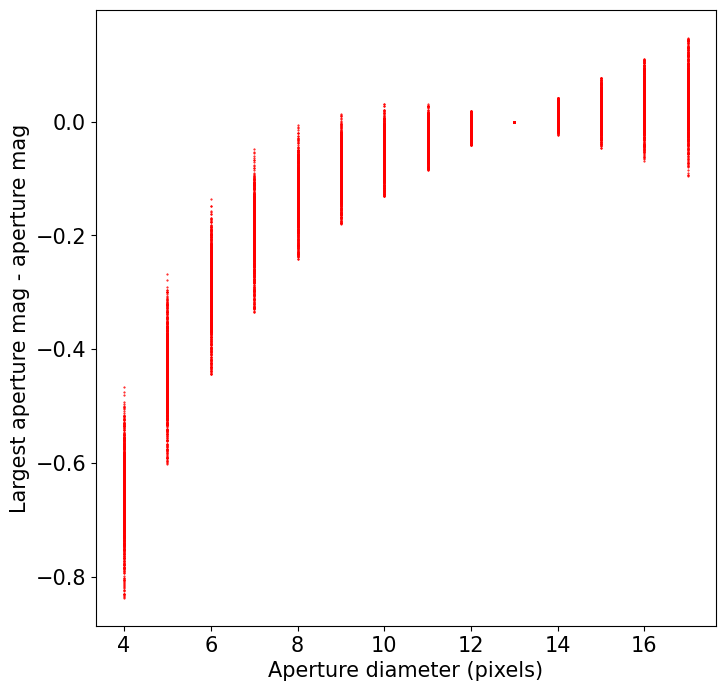

In [27]:
aperture_diameter = np.arange(4, 18)

#For each aperture, we are going to compute the magniutde difference between the largest pixel aperture and that specific aperture for every source in cross-matched catalog
magDiff = np.ma.zeros((len(aperture_diameter), len(local_idx)))
for j in range(len(aperture_diameter)):
    magDiff[j] = sigma_clip(unflagged_sources['MAG_APER'][:,9][local_idx] - unflagged_sources['MAG_APER'][:,j][local_idx])
#Here, magDiff is a 2D array contaning the difference magnitudes for each source and aperture
    
#Now, let's plot the magnitude differences 
plt.figure(figsize = (8,8))
plt.plot(aperture_diameter, magDiff, 'r.', markersize=1)
plt.xlabel('Aperture diameter (pixels)', fontsize=15)
plt.ylabel('Largest aperture mag - aperture mag', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [25]:
a_max=int(np.round((2*medFWHM), 0))
print(a_max)

aperture_diameter = np.arange(5,a_max+1)
print(aperture_diameter)
print(len(aperture_diameter), len(local_idx))
zero_points = []
for i in range(len(aperture_diameter)):
    offsets = np.ma.array(good_stars['gmag'][pan_idx] - unflagged_sources['MAG_APER'][:,i][local_idx])
    zero_mean, zero_med, zero_std = sigma_clipped_stats(offsets)
    zp_dict = {'diameter': aperture_diameter[i], 'zp_mean': np.round(zero_mean,3), 'zp_median': np.round(zero_med,3), 'zp_std': np.round(zero_std, 3)}
    zero_points.append(zp_dict)
    print(zp_dict)

9
[5 6 7 8 9]
5 1381
{'diameter': 5, 'zp_mean': 25.158, 'zp_median': 25.151, 'zp_std': 0.056}
{'diameter': 6, 'zp_mean': 25.374, 'zp_median': 25.366, 'zp_std': 0.055}
{'diameter': 7, 'zp_mean': 25.519, 'zp_median': 25.512, 'zp_std': 0.056}
{'diameter': 8, 'zp_mean': 25.617, 'zp_median': 25.613, 'zp_std': 0.056}
{'diameter': 9, 'zp_mean': 25.683, 'zp_median': 25.681, 'zp_std': 0.059}


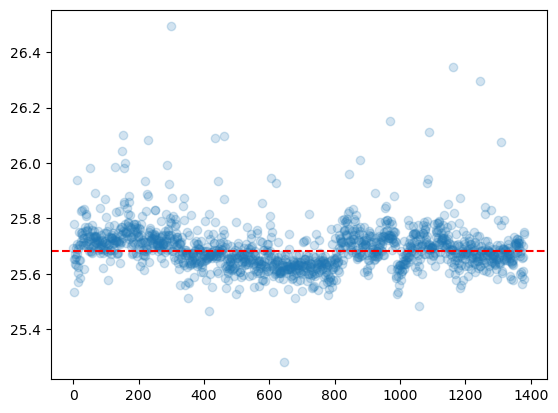

In [28]:
# Let's see how good or bad is the ZP estimation is.
plt.scatter(np.arange(len(offsets)), offsets, alpha = 0.2)
plt.axhline(zero_med, color= 'r', linestyle = '--')

You can also check the relationship between instric magnitude and magnitude from panSTARRS. They should follow a linear trend.

# So, this brings us to the next Exercise!

#### Plot the instrinsic magnitude Vs ps1 magniudes and see if they follow a linear trend or not.  

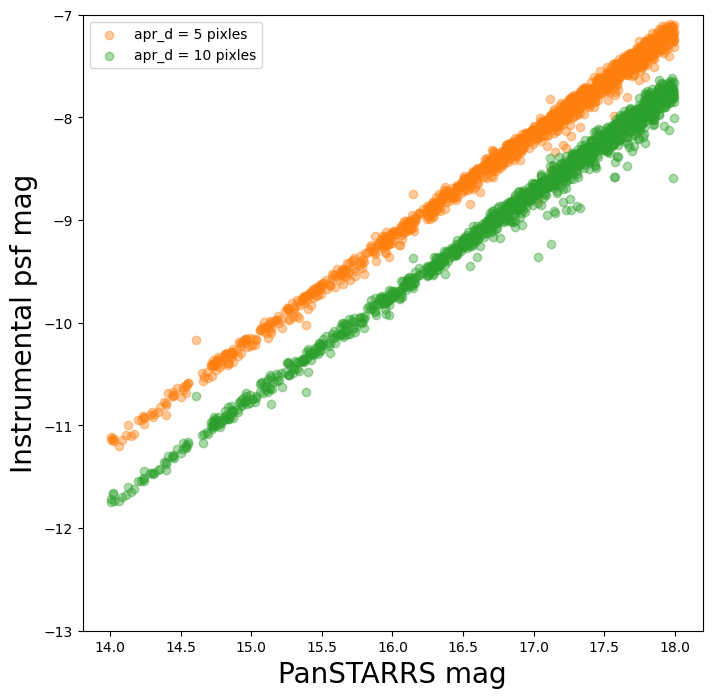

In [29]:
# Exercise 2 solution here: 
plt.figure(figsize=(8,8))
plt.scatter(good_stars['gmag'][pan_idx], unflagged_sources['MAG_APER'][:,0][local_idx], color = 'C1', label= 'apr_d = 5 pixles', alpha = 0.4)
plt.scatter(good_stars['gmag'][pan_idx], unflagged_sources['MAG_APER'][:,5][local_idx], color = 'C2',  label= 'apr_d = 10 pixles', alpha = 0.4)
plt.xlabel('PanSTARRS mag', fontsize=20)
plt.ylabel('Instrumental psf mag', fontsize=20)
plt.ylim(-13,-7)
plt.legend()
plt.show()

In [30]:
ra = 324.8157058   # RA of the source
dec = 46.7339800   # Dec of the source

position = SkyCoord(ra = ra, dec = dec, unit = u.deg, frame = 'icrs')

radii_max =int(np.round(medFWHM, 0))
aperture_radii= np.arange(1,radii_max+1)
print(aperture_radii)

apertures = [SkyCircularAperture(position, r = r * u.arcsec) for r in aperture_radii]
pix_apertures = [a.to_pixel(w) for a in apertures]

phot_table = aperture_photometry(data, pix_apertures)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

[1 2 3 4]
 id  xcenter   ycenter  aperture_sum_0 aperture_sum_1 aperture_sum_2 aperture_sum_3
       pix       pix                                                               
--- --------- --------- -------------- -------------- -------------- --------------
  1 2106.0778 2050.4611      5050.6696      13885.843      20594.828      26008.073


In [31]:
# Create the annulus aperture for background estimation
anuRadius = int(np.round(4*medFWHM, 0))
anuWidth =  3

annulus_aperture = SkyCircularAnnulus(position, r_in = anuRadius * u.arcsec, r_out = (anuRadius + anuWidth) * u.arcsec)
pix_annulus_aperture = annulus_aperture.to_pixel(w)

#Measuring the flux inside an aperture annulus
error = np.sqrt(data)  # error array for each pixel value.
annulus_phot_table = aperture_photometry(data, pix_annulus_aperture, error = error)
for col in annulus_phot_table.colnames:
        annulus_phot_table[col].info.format = '%.8g'
#print the output
print(annulus_phot_table)

 id  xcenter   ycenter  aperture_sum aperture_sum_err
       pix       pix                                 
--- --------- --------- ------------ ----------------
  1 2106.0778 2050.4611    67566.876        259.93629


In [32]:
bkg_mean = annulus_phot_table['aperture_sum'] / pix_annulus_aperture.area
bkg_flux = bkg_mean * pix_apertures[-1].area
print('aperture_sum_%d'%i)
source_flux = phot_table['aperture_sum_%d'%(radii_max-1)] - bkg_flux
int_mag_err=2.5*np.log10(1 + annulus_phot_table['aperture_sum_err'] / source_flux)
e_mag= np.sqrt(int_mag_err**2+zero_points[-1]['zp_std']**2)
source_mag = zero_points[-1]['zp_median'] - 2.5 * np.log10(source_flux)
print('Found source magnitude of %.2f +/- %0.2f for aperture of radius %d pixels'%(source_mag, e_mag, aperture_radii[-1]))

aperture_sum_4
Found source magnitude of 15.12 +/- 0.06 for aperture of radius 4 pixels


# PSF-fit photometry:


In [33]:
psf_config = 'config.psfex'
psfex_command =  ['psfex', '-c', psf_config, out_cat]
print('PSFEx command is : %s'%psfex_command)
try:
    display_text("Running PSFEx")
    wait_request()
    rval = subprocess.call(psfex_command)
    display_text("Process complete")
except subprocess.CalledProcessError as err:
    print('An error occuered while running PSFEx on %s. Please try to run it manually through terminal.'%image)
    sys.exit(1)

PSFEx command is : ['psfex', '-c', 'config.psfex', 'C0_20181013-190734-760.wcs.proc.fits.cat']
*-----------------------*
*---  Running PSFEx  ---*
*-----------------------*

This step may take a while. Please wait 🙏.




> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.


> WARNING: Not a positive definite matrix in PSF model solver


> WARNING: Not a positive definite matrix in PSF model solver



*--------------------------*
*---  Process complete  ---*
*--------------------------*



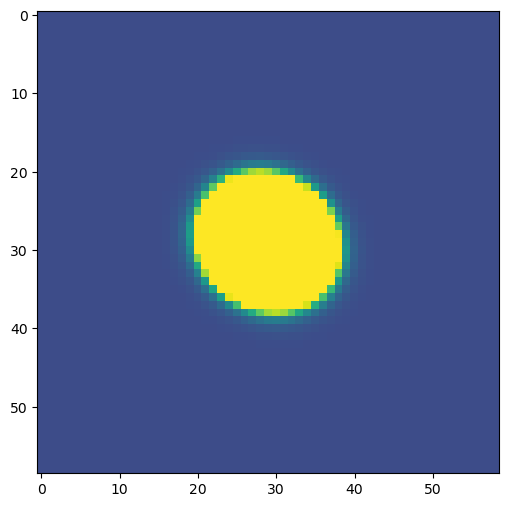

In [34]:
psf_hdu = fits.open('moffat_'+image+'.fits')[0]
psf_data = psf_hdu.data
psf_mean, psf_median, psf_std = sigma_clipped_stats(psf_data)
plt.figure(figsize=(6,6))
plt.imshow(psf_data, vmin = psf_median - 3*psf_std, vmax = psf_median + 10*psf_std)
plt.show()

In [35]:
psf_model = image + '.psf'
out_psfcat = image+'.psf.cat'
parameter_file = 'photomPSF.param'  # psf photometry parameter file for SExtrator

# Let's run sextrator again. But, this time with psf model as input to perform psf photometry.
command = ['sex', image, '-c', conf_file, '-CATALOG_NAME', out_psfcat, '-PARAMETERS_NAME', parameter_file, '-PSF_NAME', psf_model]  
try:
    display_text("Running SExtractor")
    wait_request()
    rval = subprocess.call(command)
    display_text("Process complete")
except subprocess.CalledProcessError as err:
    print('An error occuered while running SExtractor. Please try to run it manually through terminal.')
    sys.exit(1)

*----------------------------*
*---  Running SExtractor  ---*
*----------------------------*

This step may take a while. Please wait 🙏.



> 
----- SExtractor 2.28.0 started on 2024-07-08 at 14:07:10 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for C0_20181013-190734-760.wcs.proc.fits
----- Measuring from: C0_20181013-190734-760.wcs.proc.fits
      " " / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  512
> Setting up background map at line: 1024
> Setting up background map at line: 1536
> Setting up background map at line: 2048
> Setting up background map at line: 2560
> Setting up background map at line: 3072
> Setting up background map at line: 3584
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Backgroun

*--------------------------*
*---  Process complete  ---*
*--------------------------*



> Line: 4108  Objects:     6472 detected /     6130 sextracted
> Line: 4108  Objects:     6472 detected /     6140 sextracted
> Line: 4108  Objects:     6472 detected /     6150 sextracted
      Objects: detected 6472     / sextracted 6160            

> Closing files
> 
> All done (in 31.8 s: 129.3 lines/s , 193.8 detections/s)


In [36]:
local_psfsources = load_catalogue(out_psfcat)

# Spend a minute on comparing the new and older sextrator catalogue table columns and see what now in recent catalogue.
print(local_psfsources.colnames)

print("\n\nFound {} sources".format(len(local_psfsources)))

['VIGNET', 'X_IMAGE', 'Y_IMAGE', 'XWIN_IMAGE', 'YWIN_IMAGE', 'ERRAWIN_IMAGE', 'ERRBWIN_IMAGE', 'ALPHAWIN_J2000', 'DELTAWIN_J2000', 'FLUX_RADIUS', 'FWHM_WORLD', 'FLUX_AUTO', 'FLUXERR_AUTO', 'SNR_WIN', 'ELONGATION', 'FLUX_MAX', 'MAG_AUTO', 'MAGERR_AUTO', 'FLAGS', 'BACKGROUND', 'CLASS_STAR', 'FLAGS_MODEL', 'NITER_MODEL', 'XMODEL_IMAGE', 'YMODEL_IMAGE', 'FLUX_POINTSOURCE', 'FLUXERR_POINTSOURCE', 'MAG_POINTSOURCE', 'MAGERR_POINTSOURCE', 'FLUXRATIO_POINTSOURCE', 'FLUXRATIOERR_POINTSOURCE']


Found 6160 sources


In [37]:
# Selecting good sources:
unflagged_psfsources = local_psfsources[(local_psfsources['FLAGS']==0) & (local_psfsources['FLAGS_MODEL']==0)  & (local_psfsources['FWHM_WORLD']*3600 < 5)]

In [38]:
local_psf_catcoords = SkyCoord(ra=unflagged_psfsources['ALPHAWIN_J2000'], dec=unflagged_psfsources['DELTAWIN_J2000'], frame='icrs', unit='degree')
cross_match_radius = 0.676
local_psfidx, pan_psfidx, d2d, d3d = pan_catcoords.search_around_sky(local_psf_catcoords, cross_match_radius*u.arcsec)

print('Found %d good cross-matches'%len(local_psfidx))

Found 1378 good cross-matches


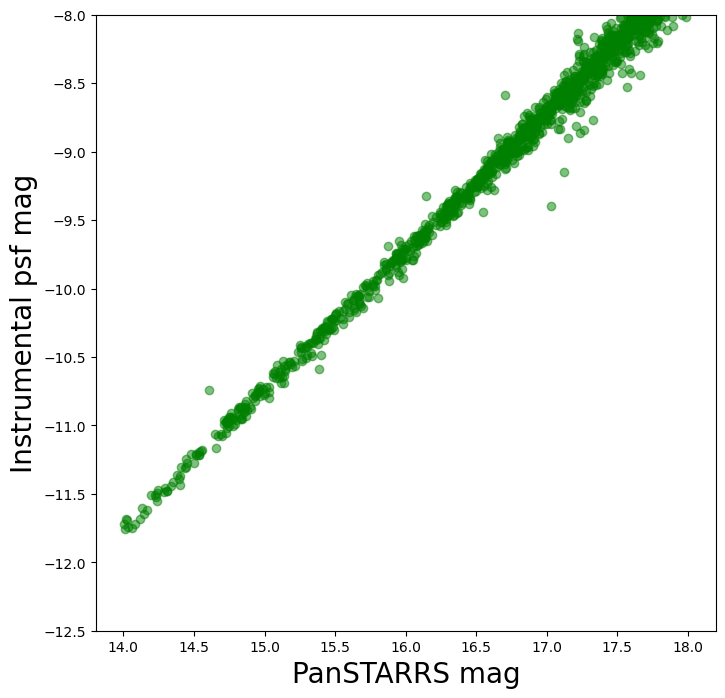

In [39]:
plt.figure(figsize=(8,8))
plt.plot(good_stars['gmag'][ pan_psfidx], unflagged_psfsources['MAG_POINTSOURCE'][local_psfidx] , 'go', alpha = 0.5)
plt.xlabel('PanSTARRS mag', fontsize=20)
plt.ylabel('Instrumental psf mag', fontsize=20)
plt.ylim(-12.5, -8)
plt.show()

In [40]:
# Get the zeropoint of the image by crossd matching the psf photometry of sources. 
psfoffsets = np.ma.array(good_stars['gmag'][ pan_psfidx] - unflagged_psfsources['MAG_POINTSOURCE'][local_psfidx])
zp_psfmean, zp_psfmed, zp_psfstd = sigma_clipped_stats(psfoffsets)
print('PSF mean zp: %.3f, PSF median zp: %.3f,  PSF std zp: %.3f'%(zp_psfmean, zp_psfmed, zp_psfstd))

PSF mean zp: 25.720, PSF median zp: 25.717,  PSF std zp: 0.066


In [41]:
target_coords = SkyCoord(ra=[ra], dec=[dec], frame='icrs', unit='degree')
idx_target, local_idx_psf_target, d2d, d3d = local_psf_catcoords.search_around_sky(target_coords, cross_match_radius*u.arcsec)
if len(local_idx_psf_target) > 0:
    print('Source found in SExtrator catalogue')
else:
    print("Unable to locate source in SExtrator catalogue")

int_psf_mag = unflagged_psfsources[local_idx_psf_target]['MAG_POINTSOURCE'][0]
int_psf_magerr = unflagged_psfsources[local_idx_psf_target]['MAGERR_POINTSOURCE'][0]

psfmag =  int_psf_mag + zp_psfmed
e_psfmag = np.sqrt(int_psf_magerr**2 + zp_psfstd**2)

Source found in SExtrator catalogue


In [42]:
print('PSF magnitude of target is %.2f +/- %.2f'%(psfmag, e_psfmag))

PSF magnitude of target is 15.15 +/- 0.07


# Need of Image subtraction


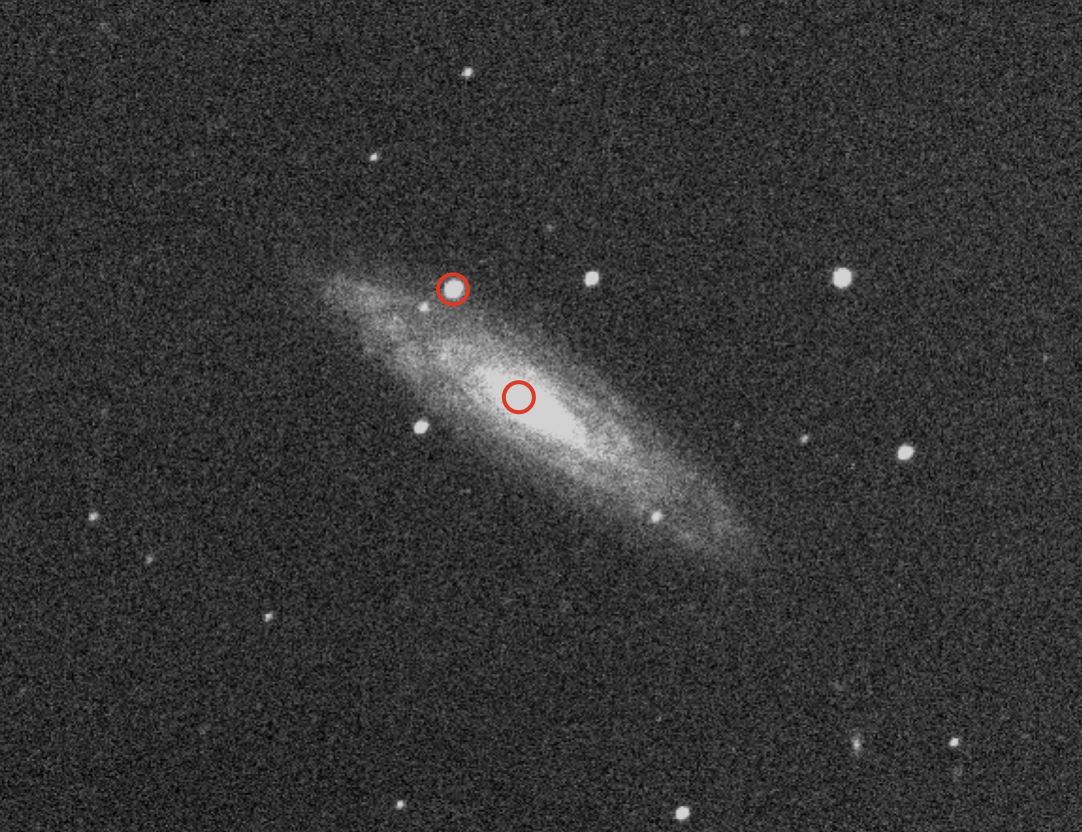